# 차량 번호판 인식

In [ ]:
# !pip install pytesseract

## 1. 사진 출력

In [13]:
def gray_image(img):
    plt.style.use('dark_background')

#     img = cv2.imread('sample_photo/Car_num1.jpg')
    height, width, channel = img.shape
#     print(height, width, channel)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.figure(figsize=(12, 10))
    plt.imshow(gray, cmap='gray')
    return gray

## 2. edge 검출

In [14]:
def edge_image(gray):
    structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
    imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

    imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
    gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)
    img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

    img_thresh = cv2.adaptiveThreshold(
        img_blurred, 
        maxValue=255.0, 
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        thresholdType=cv2.THRESH_BINARY_INV, 
        blockSize=19, 
        C=9
    )

#     cv2.imshow('imgTopHat', imgTopHat)
#     cv2.imshow('imgBlackHat', imgBlackHat)
#     cv2.imshow('img_blurred', img_blurred)

#     cv2.waitKey()
#     cv2.destroyAllWindows()

#     plt.figure(figsize=(12, 10))
#     plt.imshow(img_thresh, cmap='gray')
    return img_thresh

## 3. contours 추출

In [15]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# import pytesseract
# import PIL

def contours(img, img_thresh):
    height, width, channel = img.shape

    contours, _= cv2.findContours(img_thresh, cv2.RETR_TREE,
                                  cv2.CHAIN_APPROX_SIMPLE)

    temp_result = np.zeros((height, width, channel), dtype=np.uint8)

    cv2.drawContours(temp_result, contours=contours, contourIdx=-1, 
                     color=(255, 255, 255))

    temp_result = np.zeros((height, width, channel), dtype=np.uint8)

    contours_dict = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), 
                      color=(255, 255, 255), thickness=2)


        contours_dict.append({
            'contour': contour,
            'x': x,
            'y': y,
            'w': w,
            'h': h,
            'cx': x + (w / 2),
            'cy': y + (h / 2)
        })

#         print(contours_dict)


    # cv2.imshow('contours', contours)
    # cv2.imshow('temp_result', temp_result)

    # cv2.waitKey()
    # cv2.destroyAllWindows()    


#     plt.figure(figsize=(12, 10))
#     plt.imshow(temp_result, cmap='gray')
    
    return temp_result, contours_dict

## Contour 배열 버블정렬

In [16]:
def bubble_sort(img, temp_result, contours_dict):
    height, width, channel = img.shape

#     MIN_AREA = 80
#     MIN_WIDTH, MIN_HEIGHT = 2, 8
#     MIN_RATIO, MAX_RATIO = 0.25, 1.0

    possible_contours = []

    cnt = 0
    for d in contours_dict:
        area = d['w'] * d['h']
        ratio = d['w'] / d['h']

        if area > MIN_AREA \
        and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            d['idx'] = cnt
            cnt += 1
            possible_contours.append(d)

    temp_result = np.zeros((height, width, channel), dtype=np.uint8)

    for d in possible_contours:

        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), 
                      color=(255, 255, 255), thickness=2)

#     plt.figure(figsize=(12, 10))
#     plt.imshow(temp_result, cmap='gray')
    
    return temp_result, possible_contours

In [17]:
def find_chars(contour_list):
    
#     MAX_DIAG_MULTIPLYER = 5 
#     MAX_ANGLE_DIFF = 12.0 
#     MAX_AREA_DIFF = 0.5 
#     MAX_WIDTH_DIFF = 0.8
#     MAX_HEIGHT_DIFF = 0.2
#     MIN_N_MATCHED = 3

    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, 
                                    unmatched_contour_idx)
        
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break
        
    return matched_result_idx
    
# result_idx = find_chars(possible_contours)

In [18]:
def find_chars_2(img, result_idx, possible_contours):
    height, width, channel = img.shape
    matched_result = []
    for idx_list in result_idx:
        matched_result.append(np.take(possible_contours, idx_list))

    temp_result = np.zeros((height, width, channel), dtype=np.uint8)

    for r in matched_result:
        for d in r:

            cv2.rectangle(temp_result, pt1=(d['x'], d['y']), 
                          pt2=(d['x']+d['w'], d['y']+d['h']), 
                          color=(255, 255, 255), thickness=2)

#     plt.figure(figsize=(12, 10))
#     plt.imshow(temp_result, cmap='gray')

    return temp_result, matched_result

# 번호판 추출

In [19]:
def crop_img(img, matched_result):
    height, width, channel = img.shape
    
#     PLATE_WIDTH_PADDING = 1.3
#     PLATE_HEIGHT_PADDING = 1.5
#     MIN_PLATE_RATIO = 3
#     MAX_PLATE_RATIO = 10

    plate_imgs = []
    plate_infos = []

    for i, matched_chars in enumerate(matched_result):
        sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

        plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
        plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2

        plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x'])\
            * PLATE_WIDTH_PADDING

        sum_height = 0
        for d in sorted_chars:
            sum_height += d['h']

        plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)

        triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
        triangle_hypotenus = np.linalg.norm(
            np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
            np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
        )

        angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))

        rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy),
                                                  angle=angle, scale=1.0)

        img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))

        img_cropped = cv2.getRectSubPix(
            img_rotated, 
            patchSize=(int(plate_width), int(plate_height)), 
            center=(int(plate_cx), int(plate_cy))
        )

        if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or\
        img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
            continue

        plate_imgs.append(img_cropped)
        plate_infos.append({
            'x': int(plate_cx - plate_width / 2),
            'y': int(plate_cy - plate_height / 2),
            'w': int(plate_width),
            'h': int(plate_height)
        })

#         plt.subplot(len(matched_result), 1, i+1)
#         plt.imshow(img_cropped, cmap='gray')
        
    return plate_imgs, img_cropped

In [20]:
# !pip install pytesseract
# !pip install --upgrade pip

# 번호 추출

In [40]:
def final(plate_imgs, MIN_AREA, MIN_WIDTH, MIN_HEIGHT, MIN_RATIO, MAX_RATIO):
    longest_idx, longest_text = -1, 0
    plate_chars = []

    for i, plate_img in enumerate(plate_imgs):
        plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
        
        _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0,
                                     type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        contours, _= cv2.findContours(plate_img, mode=cv2.RETR_LIST,
                                      method = cv2.CHAIN_APPROX_SIMPLE)
        plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
        plate_max_x, plate_max_y = 0, 0

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)

            area = w * h
            ratio = w / h

            if area > MIN_AREA \
            and w > MIN_WIDTH and h > MIN_HEIGHT \
            and MIN_RATIO < ratio < MAX_RATIO:
                if x < plate_min_x:
                    plate_min_x = x
                if y < plate_min_y:
                    plate_min_y = y
                if x + w > plate_max_x:
                    plate_max_x = x + w
                if y + h > plate_max_y:
                    plate_max_y = y + h

        img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]

        img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
        
        _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0,
                                      type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        
        img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10,
                                        right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))

        pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'
        chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 7 --oem 0')

        result_chars = ''
        has_digit = False
        for c in chars:
            if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
                if c.isdigit():
                    has_digit = True
                result_chars += c

        print("번호판 : ", result_chars)
        plate_chars.append(result_chars)

        if has_digit and len(result_chars) > longest_text:
            longest_idx = i

        plt.subplot(len(plate_imgs), 1, i+1)
        plt.imshow(img_result, cmap='gray')
        
    return result_chars

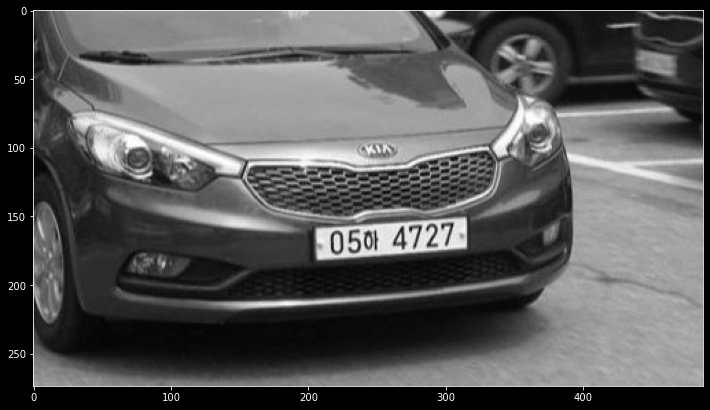

In [63]:
# 함수 실행
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
import PIL

# 사진 출력
img = cv2.imread('sample_photo/Car_number/Car_num1.jpg')

# prams
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

MAX_DIAG_MULTIPLYER = 5 
MAX_ANGLE_DIFF = 12.0 
MAX_AREA_DIFF = 0.5 
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3

PLATE_WIDTH_PADDING = 1.3
PLATE_HEIGHT_PADDING = 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10


    
# 사진 흑백화
gray = gray_image(img)

# 테두리 검출
img_thresh = edge_image(gray)

# contours 추출
temp_result, contours_dict = contours(img, img_thresh)

# Contour 배열 버블정렬
temp_result, possible_contours = bubble_sort(img, temp_result, contours_dict)

# find_chars
result_idx = find_chars(possible_contours)

# find_chars2
temp_result, matched_result = find_chars_2(img, result_idx, possible_contours)

# 번호판 추출
plate_imgs, img_cropped = crop_img(img, matched_result)

번호판 :  5허4727


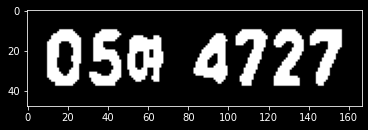

In [64]:
# 번호 영역 추출
img_result = final(plate_imgs, MIN_AREA, MIN_WIDTH, MIN_HEIGHT, MIN_RATIO, MAX_RATIO)

번호판 :  054727
번호판 :  054727
번호판 :  삐리7215
번호판 :  삐리7215
번호판 :  125가4568
번호판 :  끄섭섭겜
번호판 :  끄섭섭겜
번호판 :  틸흉핼흑겜흐쥴톨붓
번호판 :  틸흉핼흑겜흐쥴톨붓
번호판 :  찢쿡싫뻣댕끓웹촬끓
번호판 :  튼4훗우좆25훗
번호판 :  욧짤뭄짤
번호판 :  욧짤뭄짤
번호판 :  뺀즉형5노셜0281드휴7
번호판 :  뺀즉형5노셜0281드휴7
번호판 :  콜루육푸츠쿵쿵네
번호판 :  끓엠팠을
번호판 :  그쿡6엠횡
번호판 :  그쿡6엠횡
번호판 :  1601아눌
번호판 :  7캐촬쿡55구16
번호판 :  7캐촬쿡55구16
번호판 :  1솜오717
번호판 :  1솜오717
번호판 :  바굼짤츰겜흐쏟힛
번호판 :  바굼짤츰겜흐쏟힛


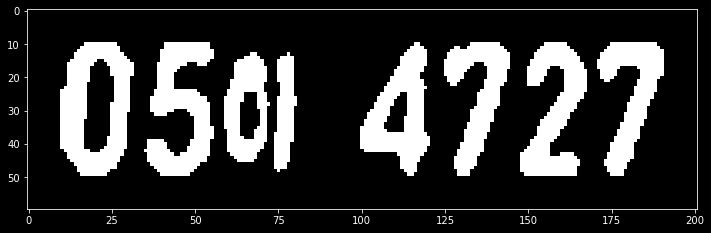

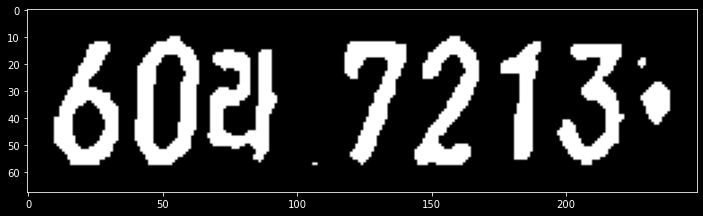

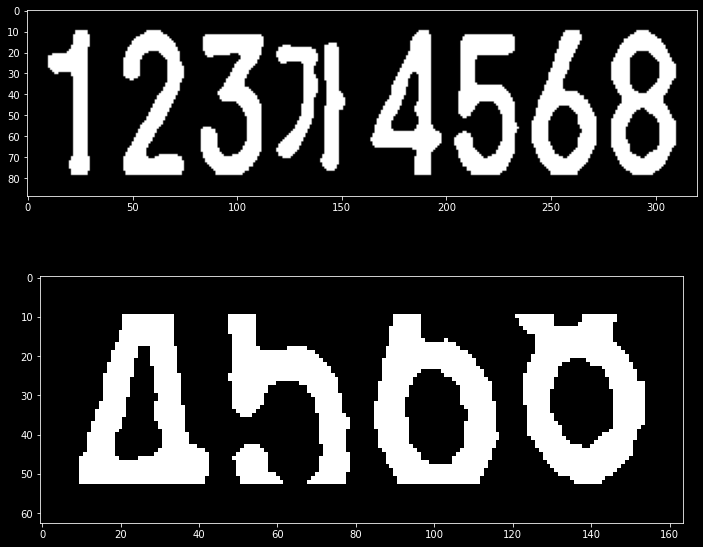

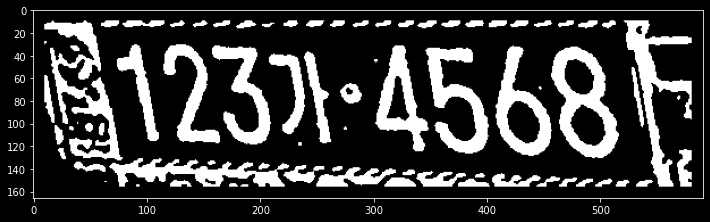

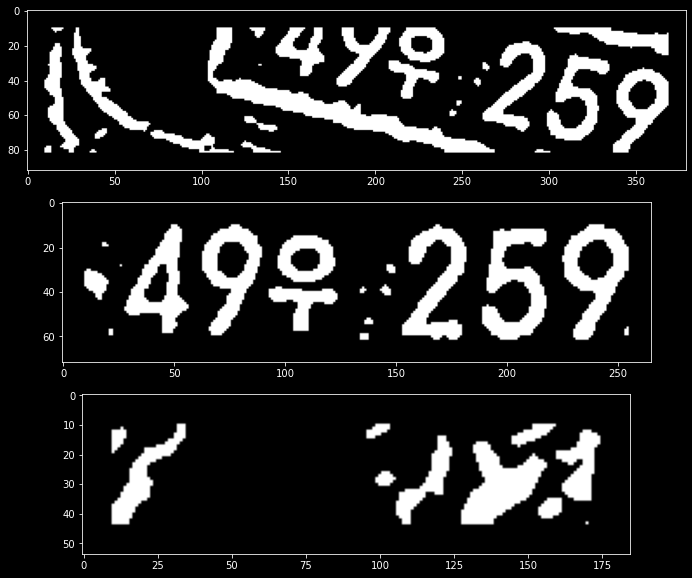

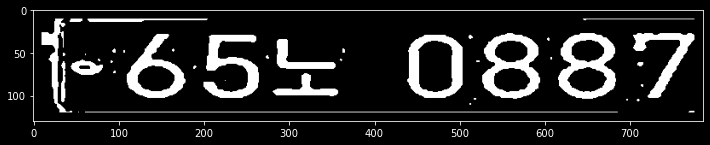

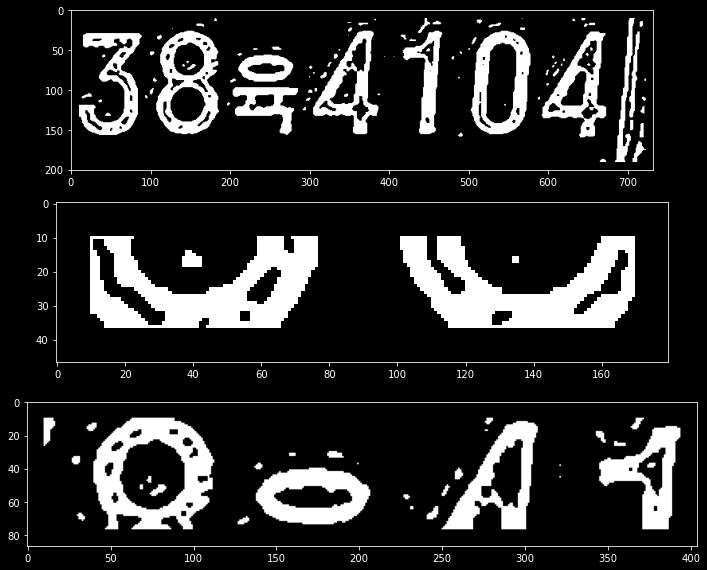

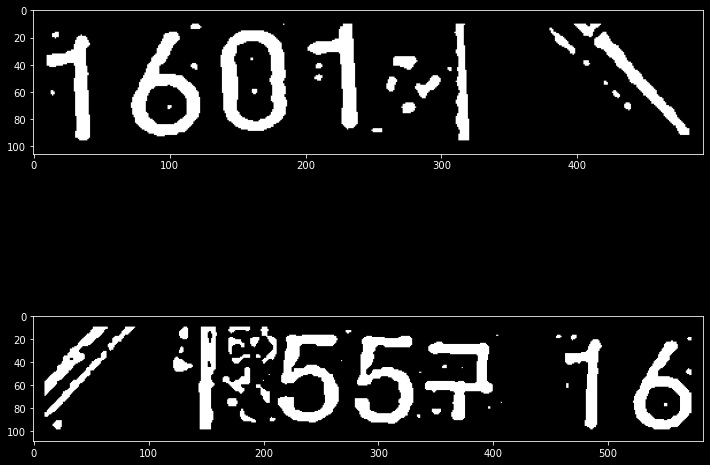

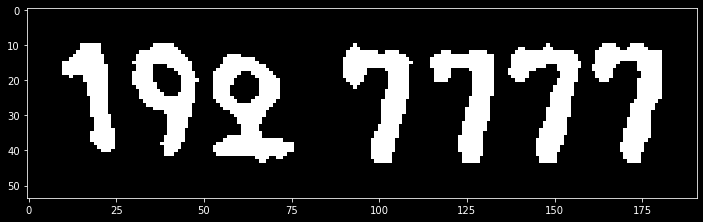

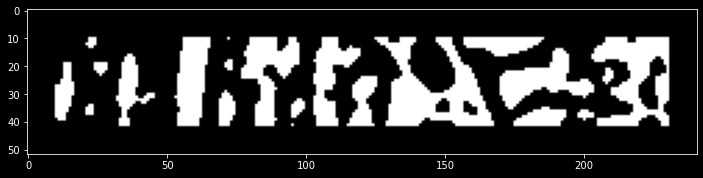

In [65]:
# 함수 실행 + 반복문
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
import PIL
import os

# 사진 리스트 생성
Carimg_path = os.listdir('sample_photo/Car_number/')

for i in Carimg_path:
    img = cv2.imread('sample_photo/Car_number/' + i)
    img = cv2.resize(img, (600, 390), interpolation = cv2.INTER_AREA)

    # prams
    MIN_AREA = 80
    MIN_WIDTH, MIN_HEIGHT = 2, 8
    MIN_RATIO, MAX_RATIO = 0.25, 1.0

    MAX_DIAG_MULTIPLYER = 5 
    MAX_ANGLE_DIFF = 12.0 
    MAX_AREA_DIFF = 0.5 
    MAX_WIDTH_DIFF = 0.8
    MAX_HEIGHT_DIFF = 0.2
    MIN_N_MATCHED = 3

    PLATE_WIDTH_PADDING = 1.3
    PLATE_HEIGHT_PADDING = 1.5
    MIN_PLATE_RATIO = 3
    MAX_PLATE_RATIO = 10



    # 사진 흑백화
    gray = gray_image(img)

    # 테두리 검출
    img_thresh = edge_image(gray)

    # contours 추출
    temp_result, contours_dict = contours(img, img_thresh)

    # Contour 배열 버블정렬
    temp_result, possible_contours = bubble_sort(img, temp_result, contours_dict)

    # find_chars
    result_idx = find_chars(possible_contours)

    # find_chars2
    temp_result, matched_result = find_chars_2(img, result_idx, possible_contours)

    # 번호판 추출
    plate_imgs, img_cropped = crop_img(img, matched_result)

    # 번호 영역 추출
    result_chars = final(plate_imgs, MIN_AREA, MIN_WIDTH, MIN_HEIGHT, MIN_RATIO, MAX_RATIO)
    print("번호판 : ", result_chars)

In [1]:
import os
import numpy as np
import cv2
import sys
import time

Carimg_path = os.listdir('sample_photo/Car_number/')

for i in Carimg_path:
    img = cv2.imread('sample_photo/Car_number/' + i)
    img = cv2.resize(img, (600, 390), interpolation = cv2.INTER_AREA)
    
    cv2.imshow('img', img)
    print(i)
    cv2.waitKey()
cv2.waitKey(0)  
cv2.destroyAllWindows

Car_num1.jpg
Car_num10.jpg
Car_num2.png
Car_num3.jpg
Car_num4.jpg
Car_num5.jpg
Car_num6.jpg
Car_num7.jpg
Car_num8.jpg
Car_num9.jpg


<function destroyAllWindows>

### [출처] [Python] 파이썬, OpenCV, 차량번호판인식|작성자 hckim

In [2]:
# !pip install opencv-contrib-python

In [49]:
# !pip install ipykernel
# !pip install tensorflow_hub

     -------------------------------------- 108.8/108.8 KB 3.2 MB/s eta 0:00:00


해상도를 올려주는 모델인줄 알았으나 이미지를 합쳐주는 모델이였음

In [31]:
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow as tf
from PIL import Image
import numpy as np
import cv2
import sys

##########모델 로드

model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

print(model.signatures.keys()) #KeysView(_SignatureMap({'serving_default': <tensorflow.python.saved_model.load._WrapperFunction object at 0x146e5f8d0>}))
print(model.signatures['serving_default'].structured_input_signature) #((), {'placeholder_1': TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='placeholder_1'), 'placeholder': TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='placeholder')})
print(model.signatures['serving_default'].structured_outputs) #{'output_0': TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='output_0')}

##########모델 예측

file_path = tf.keras.utils.get_file('640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg', 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg')
image = Image.open(file_path)
image = image.convert('RGB') #'L': greyscale, '1': 이진화, 'RGB' , 'RGBA', 'CMYK'
image = image.resize((256, 256))
image_numpy = np.array(image)
x_test = np.array([image_numpy])
#특성 스케일링
x_test = x_test / 255
#저장된 모델 숫자 사용시 32 비트 사용
x_test = x_test.astype(dtype=np.float32)
#저장된 모델 시그니처 사용시 텐서 사용
x_test = tf.constant(x_test)
content_image = x_test
print("content_image.shape", content_image.shape)

file_path = tf.keras.utils.get_file('The_Great_Wave_off_Kanagawa.jpg', 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg')
image = Image.open(file_path)
image = image.convert('RGB') #'L': greyscale, '1': 이진화, 'RGB' , 'RGBA', 'CMYK'
# Optionally resize the images. It is recommended that the style image is about
# 256 pixels (this size was used when training the style transfer network).
# The content image can be any size.
image = image.resize((256, 256))
image_numpy = np.array(image)
x_test = np.array([image_numpy])
#특성 스케일링
x_test = x_test / 255
#저장된 모델 숫자 사용시 32 비트 사용
x_test = x_test.astype(dtype=np.float32)
#저장된 모델 시그니처 사용시 텐서 사용
x_test = tf.constant(x_test)
style_image = x_test
print("style_image.shape", style_image.shape)

y_predict = model(content_image, style_image)[0].numpy()
#y_predict = model(placeholder_1=content_image, placeholder=style_image)[0]
print("y_predict.shape", y_predict.shape)

image = Image.fromarray((y_predict[0] * 255).astype(np.uint8))
image.save('out.png')


# [출처 - 토닥토닥 파이썬]https://wikidocs.net/80781

KeysView(_SignatureMap({'serving_default': <ConcreteFunction signature_wrapper(placeholder, placeholder_1) at 0x2A71E7773A0>}))
((), {'placeholder': TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='placeholder'), 'placeholder_1': TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='placeholder_1')})
{'output_0': TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='output_0')}
content_image.shape (1, 256, 256, 3)
style_image.shape (1, 256, 256, 3)
y_predict.shape (1, 256, 256, 3)
